In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import minmax_scale, StandardScaler
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
from rdkit.ML.Descriptors import MoleculeDescriptors

In [2]:
# Load data
tested = pd.read_csv("data/tested_molecules.csv")

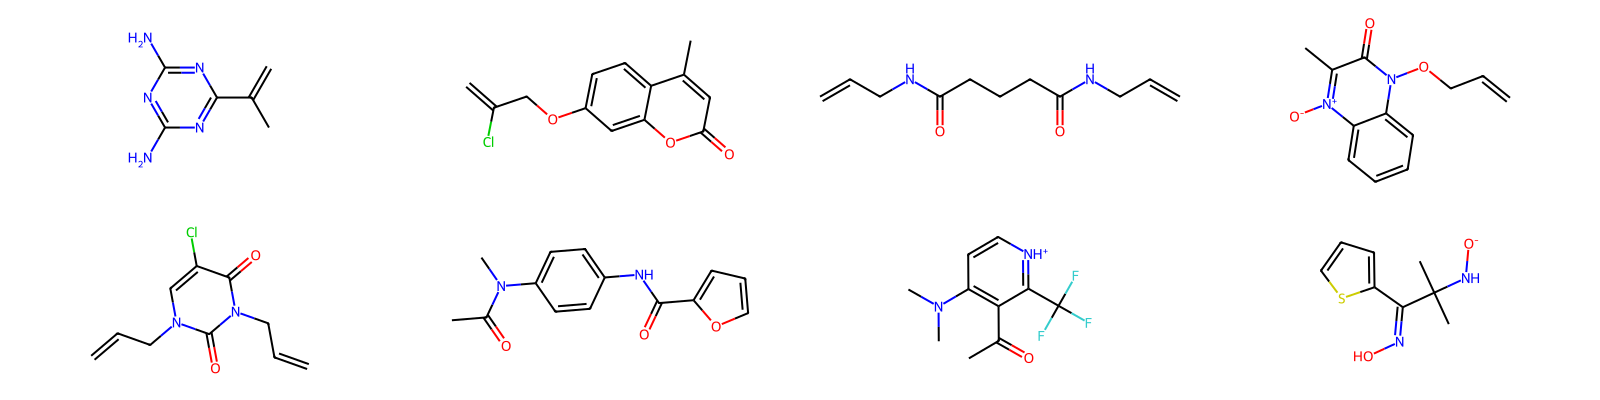

In [3]:
smiles = tested['SMILES']
mols = [Chem.MolFromSmiles(smi) for smi in smiles]
Draw.MolsToGridImage(mols[0:8], molsPerRow=4, subImgSize=(400, 200))

In [4]:
MoleculeDescriptors.MolecularDescriptorCalculator(['fr_ketone']).GetDescriptorSummaries()

['Number of ketones']

In [5]:
# 1. Dataset preparation with RDKit, e.g., calculation of various types of molecular descriptors.

In [6]:
# 2D Descriptors
desc_list = [x[0] for x in Descriptors._descList]
calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)
rdkit_desc = [calc.CalcDescriptors(m) for m in mols]  # our rdkit descriptors: 1116 rows by 210 cols

# Create 2d descriptor dataframe
desc_names = calc.GetDescriptorNames()
df_desc_2d = pd.DataFrame(rdkit_desc, columns=desc_names)
df_desc_2d.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.313889,5.313889,0.120833,0.120833,0.592228,9.545455,151.173,142.101,151.085795,58,...,0,0,0,0,0,0,0,0,0,0
1,11.238954,11.238954,0.225308,-0.366756,0.785414,10.470588,250.681,239.593,250.039672,88,...,0,0,0,0,0,0,0,0,0,0
2,11.090706,11.090706,0.049610,-0.049610,0.581062,9.066667,210.277,192.133,210.136828,84,...,0,0,0,0,0,0,0,0,0,0
3,11.892238,11.892238,0.076632,-0.457824,0.441090,10.411765,232.239,220.143,232.084792,88,...,0,0,0,0,0,0,0,0,0,0
4,11.693580,11.693580,0.012315,-0.498260,0.720343,9.933333,226.663,215.575,226.050905,80,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Binary (Morgan) ECFP6 fingerprints
radius = 2  # 2 for similarity exploration, 3 for ML
nBits = 1024  # 2048 is default, 1024 is also fine

# Calculate binary ECFP6 fingerprints:
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(m , radius = radius, nBits = nBits) for m in mols]
len(fingerprints[0])

# Create fingerprint dataframe where each column represents a bit
fprint_cols = [f'Bit_{i}' for i in range(nBits)]
fprint_bits = [list(x) for x in fingerprints]
df_fprint = pd.DataFrame(fprint_bits, index = smiles, columns = fprint_cols)
df_fprint.head()

,Bit_0,Bit_1,Bit_2,Bit_3,Bit_4,Bit_5,Bit_6,Bit_7,Bit_8,Bit_9,...,Bit_1014,Bit_1015,Bit_1016,Bit_1017,Bit_1018,Bit_1019,Bit_1020,Bit_1021,Bit_1022,Bit_1023
SMILES,,,,,,,,,,,,,,,,,,,,,
C=C(C)c1nc(N)nc(N)n1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
C=CCNC(=O)CCCC(=O)NCC=C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# MACCS keys

maccs_keys = np.array([MACCSkeys.GenMACCSKeys(m) for m in mols])
col_name = [f'feature_{i}' for i in range(1, len(maccs_keys[0]) + 1)]
# Create MACCS dataframe where each column corresponds to a MACCS feature (structural feature)
df_maccs = pd.DataFrame(data = maccs_keys, index = smiles, columns = col_name)

df_maccs.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,feature_167
SMILES,,,,,,,,,,,,,,,,,,,,,
C=C(C)c1nc(N)nc(N)n1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
C=C(Cl)COc1ccc2c(C)cc(=O)oc2c1,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,0,1,1,1,1,0
C=CCNC(=O)CCCC(=O)NCC=C,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,0
C=CCOn1c(=O)c(C)[n+]([O-])c2ccccc21,0,0,0,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,1,0
C=CCn1cc(Cl)c(=O)n(CC=C)c1=O,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,1,1,1,1,1,0


In [9]:
# 2. Exploratory data analysis, outlier analysis, and descriptor selection.

In [10]:
def find_corr_cols(df, threshold):
    # Find column pairs for which correlation > threshold
    corr_ma = df.corr()  # correlation matrix; shape: (210, 210)
    col_corr = set()  # set of tuples containing column names for which corr > threshold
    for i in range(0, len(corr_ma.columns)):
        for j in range(0, i):
            if corr_ma.iloc[i, j] >= threshold:
                col1_name, col2_name = corr_ma.columns[i], corr_ma.columns[j]
                if col1_name != col2_name:
                    col_corr.add((col1_name, col2_name))
    return col_corr

def make_corr_dict(col_corr):
    # Make dictionary with as key the column name and as value the number of times the key is in a highly correlated pair.
    d = {}
    for (i, j) in col_corr:
        if i not in d.keys():
            d[i] = 1
        else:
            d[i] += 1
        if j not in d.keys():
            d[j] = 1
        else:
            d[j] += 1
    # Sort dictionary keys in descending value order
    d = dict(sorted(d.items(), key=lambda item: item[1])[::-1])
    return d


In [11]:
# Find highly correlated variables

# 2D Descriptors
d_corr_desc_2d = make_corr_dict(find_corr_cols(df_desc_2d, 0.95))
print(list(d_corr_desc_2d.keys())[0:5])  # print top 5 highly correlated variables

# Binary fingerprints
d_corr_fprint = make_corr_dict(find_corr_cols(df_fprint, 0.95))
print(list(d_corr_fprint.keys())[0:5])

# MACCS Keys
d_corr_maccs = make_corr_dict(find_corr_cols(df_maccs, 0.95))
print(list(d_corr_maccs.keys())[0:5])



['Chi0v', 'NumValenceElectrons', 'LabuteASA', 'HeavyAtomCount', 'Chi0']
[]
['feature_61', 'feature_56', 'feature_59', 'feature_52', 'feature_62']


In [12]:
# 3. Identification of structure-activity relationships, e.g., using ML concepts or insights from EDA.